In [6]:
linesCodeAnalyzer = None
with open('CodeJamCrawler/dataset/code_analyzer_output/dataset_analyzed.csv', 'r') as f:
    linesCodeAnalyzer = f.readlines()
codeAnalyzerHeader = linesCodeAnalyzer[0]
linesCodeAnalyzer = linesCodeAnalyzer[1:]
print linesCodeAnalyzer[0]

linesCccc = None
with open('outputCleared.txt', 'r') as f:
    linesCccc = f.readlines()
    
print linesCccc[0]

/home/nikola/Faks/Diplomski/DrugiSemestar/AVSP/LabAssignment/AVSP_SourceQualityPrediction/CodeJamCrawler/dataset/12_2091_53.cpp,1,35,17,33,0,2,16.50,0.00,16.50,0.94,33,0,2

csvs/08_10063_50.csv;1;61;61.000;12;12.000;0;0.000;******;******;0;0.000;0;0.000;0;0.000;4



In [14]:
def get_file_name(line, splitter):
    entries = line.split(splitter)
    file_name = entries[0].split('/')[-1]
    return file_name.split('.')[0]

In [15]:
print get_file_name(linesCodeAnalyzer[0], ',')
print get_file_name(linesCccc[0], ';')

12_2091_53
08_10063_50


In [18]:
# removing all the entries that aren't existing in outputCleared
cpp_files_only = []
for i in range(len(linesCodeAnalyzer)):
    if i % 1000 == 0:
        print i
    other = linesCodeAnalyzer[i]
    file_name_other = get_file_name(other, ',')
    found = False
    for cleared in linesCccc:
        file_name_cleared = get_file_name(cleared, ';')
        if file_name_cleared == file_name_other:
            found = True
            break
    if not found:
        continue
    cpp_files_only.append(file_name_other)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [56]:
print cpp_files_only[0]

12_2091_53


In [22]:
print 'code anal', codeAnalyzerHeader
print 'cccc', 'filename;number_of_modules;lines_of_code;lines_of_code_per_module;McCabes_cyclomatic_complexity;McCabes_cyclomatic_complexity_per_module;lines_of_comment;lines_of_comment_per_module;lines_of_code_per_line_of_comment;McCabes_cyclomatic_complexity_per_line_of_comment;IF4;IF4_per_module;IF4_visible;IF4_visible_per_module;IF4_concrete;IF4_concrete;rejected_lines_of_code'

code anal #File Name,Files,Lines,AVG Len,Code,Comments,White SP,Cd/Cm+WS,Cd/Cm,Cd/WS,% Code,Cd/File,Cm/File,WS/File,

cccc filename;number_of_modules;lines_of_code;lines_of_code_per_module;McCabes_cyclomatic_complexity;McCabes_cyclomatic_complexity_per_module;lines_of_comment;lines_of_comment_per_module;lines_of_code_per_line_of_comment;McCabes_cyclomatic_complexity_per_line_of_comment;IF4;IF4_per_module;IF4_visible;IF4_visible_per_module;IF4_concrete;IF4_concrete;rejected_lines_of_code


In [69]:
import numpy as np

def parse_cccc(cccc_line):
    name = get_file_name(cccc_line, ';')
    res = name.split('_')[-1]
    features = []
    for num in cccc_line.split(';')[1:]:
        if num == '******' or num == '------':
            num = '0.0'
        try:
            features.append(float(num))
        except ValueError:
            print num
            break
    return name, features, res


In [70]:
def parse_code_analyzer(code_anal_line):
    name = get_file_name(code_anal_line, ',')
    res = name.split('_')[-1]
    features = []
    for num in code_anal_line.split(',')[1:]:
        try:
            features.append(float(num))
        except ValueError:
            print num
            break
    return name, features, res

In [71]:
print 'cccc line vec', parse_cccc(linesCccc[0])
print 'code line vec', parse_code_analyzer(linesCodeAnalyzer[0])

cccc line vec ('08_10063_50', [1.0, 61.0, 61.0, 12.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0], '50')
code line vec ('12_2091_53', [1.0, 35.0, 17.0, 33.0, 0.0, 2.0, 16.5, 0.0, 16.5, 0.94, 33.0, 0.0, 2.0], '53')


In [73]:
cpp_files_map = set(cpp_files_only)
src_vec_map = {}

for cccc_line in linesCccc:
    name, features, res = parse_cccc(cccc_line)
    src_vec_map[name] = [features]

for code_anal_line in linesCodeAnalyzer:
    name, features, res = parse_code_analyzer(code_anal_line)
    if name in cpp_files_map:
        src_vec_map[name].append(features)
        src_vec_map[name].append(res)

In [75]:
print src_vec_map[parse_cccc(linesCccc[0])[0]]

[[1.0, 61.0, 61.0, 12.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0], [1.0, 64.0, 12.0, 63.0, 0.0, 1.0, 63.0, 0.0, 63.0, 0.98, 63.0, 0.0, 1.0], '50']


In [77]:
def create_numpy_vec(values):
    l1 = len(values[0])
    l2 = len(values[1])
    l3 = 1
    vec_len = l1 + l2 + l3
    vec = np.zeros((l1 + l2 + l3, 1))
    vec_pos = 0
    for i in range(l1):
        vec[vec_pos] = values[0][i]
        vec_pos += 1
    for i in range(l2):
        vec[vec_pos] = values[1][i]
        vec_pos += 1
    vec[vec_pos] = values[2]
    return vec

In [79]:
len(create_numpy_vec(src_vec_map[parse_cccc(linesCccc[0])[0]]))

30

In [114]:
import random
def load_dataset(src_vec_map):
    vec = src_vec_map[src_vec_map.keys()[0]]
    dim_vec = len(create_numpy_vec(vec))
    cnt_files = len(src_vec_map)
    dataset_list = []
    pos = 0
    for k in src_vec_map:
        dataset_list.append(create_numpy_vec(src_vec_map[k]))
    dataset = np.array(dataset_list)
    dataset = dataset.reshape((dataset.shape[0], dataset.shape[1]))
    return dataset

In [115]:
dataset = load_dataset(src_vec_map)

In [117]:
dataset.shape

(19153, 30)

In [156]:
dim = dataset.shape[1]

y = dataset[:,dim-1]
print y.shape
X = dataset[:, 0:dim-1]
print X.shape

(19153,)
(19153, 29)


In [157]:
def remove_same_cols(X):
    cnt_cols = X.shape[1]
    X_reduced = []
    
    for i in range(cnt_cols):
        col = dataset[:,i]
        notInside = True
        for j in range(len(X_reduced)):
            if (col == X_reduced[j]).all():
                notInside = False
        
        if notInside:
            X_reduced.append(col)

    return np.array(X_reduced).T

X = remove_same_cols(X)

In [158]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [163]:
pca.transform(X[0][:])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(1, 25)

In [3]:
def save_dataset_to_file(file_name_X, file_name_y, X, y):
    np.savetxt(file_name_X, X)
    np.savetxt(file_name_y, y)

In [169]:
#save_dataset_to_file('X.txt', 'y.txt', X, y)

In [1]:
import numpy as np
def load_dataset_from_file(features, results):
    return np.loadtxt(features), np.loadtxt(results)

In [2]:
X, y = load_dataset_from_file('X.txt', 'y.txt')
print X.shape, y.shape

(19153, 26) (19153,)


In [3]:
# y is vector of labels
def create_labels(y):
    y_l = np.copy(y)
    for i in range(y.shape[0]):
        if y[i] >= 80: 
            y_l[i] = 5
        if y[i] >= 60 and y[i] < 80: 
            y_l[i] = 4
        if y[i] >= 40 and y[i] < 60:
            y_l[i] = 3
        if y[i] >= 20 and y[i] < 40:
            y_l[i] = 2
        if y[i] < 20: 
            y_l[i] = 1
    return y_l

In [4]:
y_labeled = create_labels(y)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_labeled, test_size=0.2, random_state=0)

In [6]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_features='log2')
rfc.fit(X_train, y_train)

print rfc.score(X_test, y_test)

0.68441660141


In [7]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train) 

print clf.score(X_test, y_test)

0.61863743148


In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

print clf.score(X_test, y_test)

0.286609240407


In [7]:
from sklearn.model_selection import GridSearchCV
import multiprocessing
cores=multiprocessing.cpu_count()-2
"""
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000]}
svc = SVC()
clf = GridSearchCV(svc, parameters, n_jobs=cores, verbose=2)
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)
"""

"\nparameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000]}\nsvc = SVC()\nclf = GridSearchCV(svc, parameters, n_jobs=cores, verbose=2)\nclf.fit(X_train, y_train)\nprint clf.score(X_test, y_test)\n"

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print gbc.score(X_test, y_test)

0.334377447142


In [25]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print abc.score(X_test, y_test)

0.29313495171


In [9]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=30)
etc.fit(X_train, y_train)
print etc.score(X_test, y_test)

0.676324719394


In [29]:
print X.shape, y.reshape((y.shape[0], 1)).shape

(19153, 26) (19153, 1)


In [30]:
#dataset = X#np.concatenate((X, y.T), axis=1)

dataset = np.concatenate((X,y[:,None]),axis=1)
#print X.shape[0] == y.shape[0]

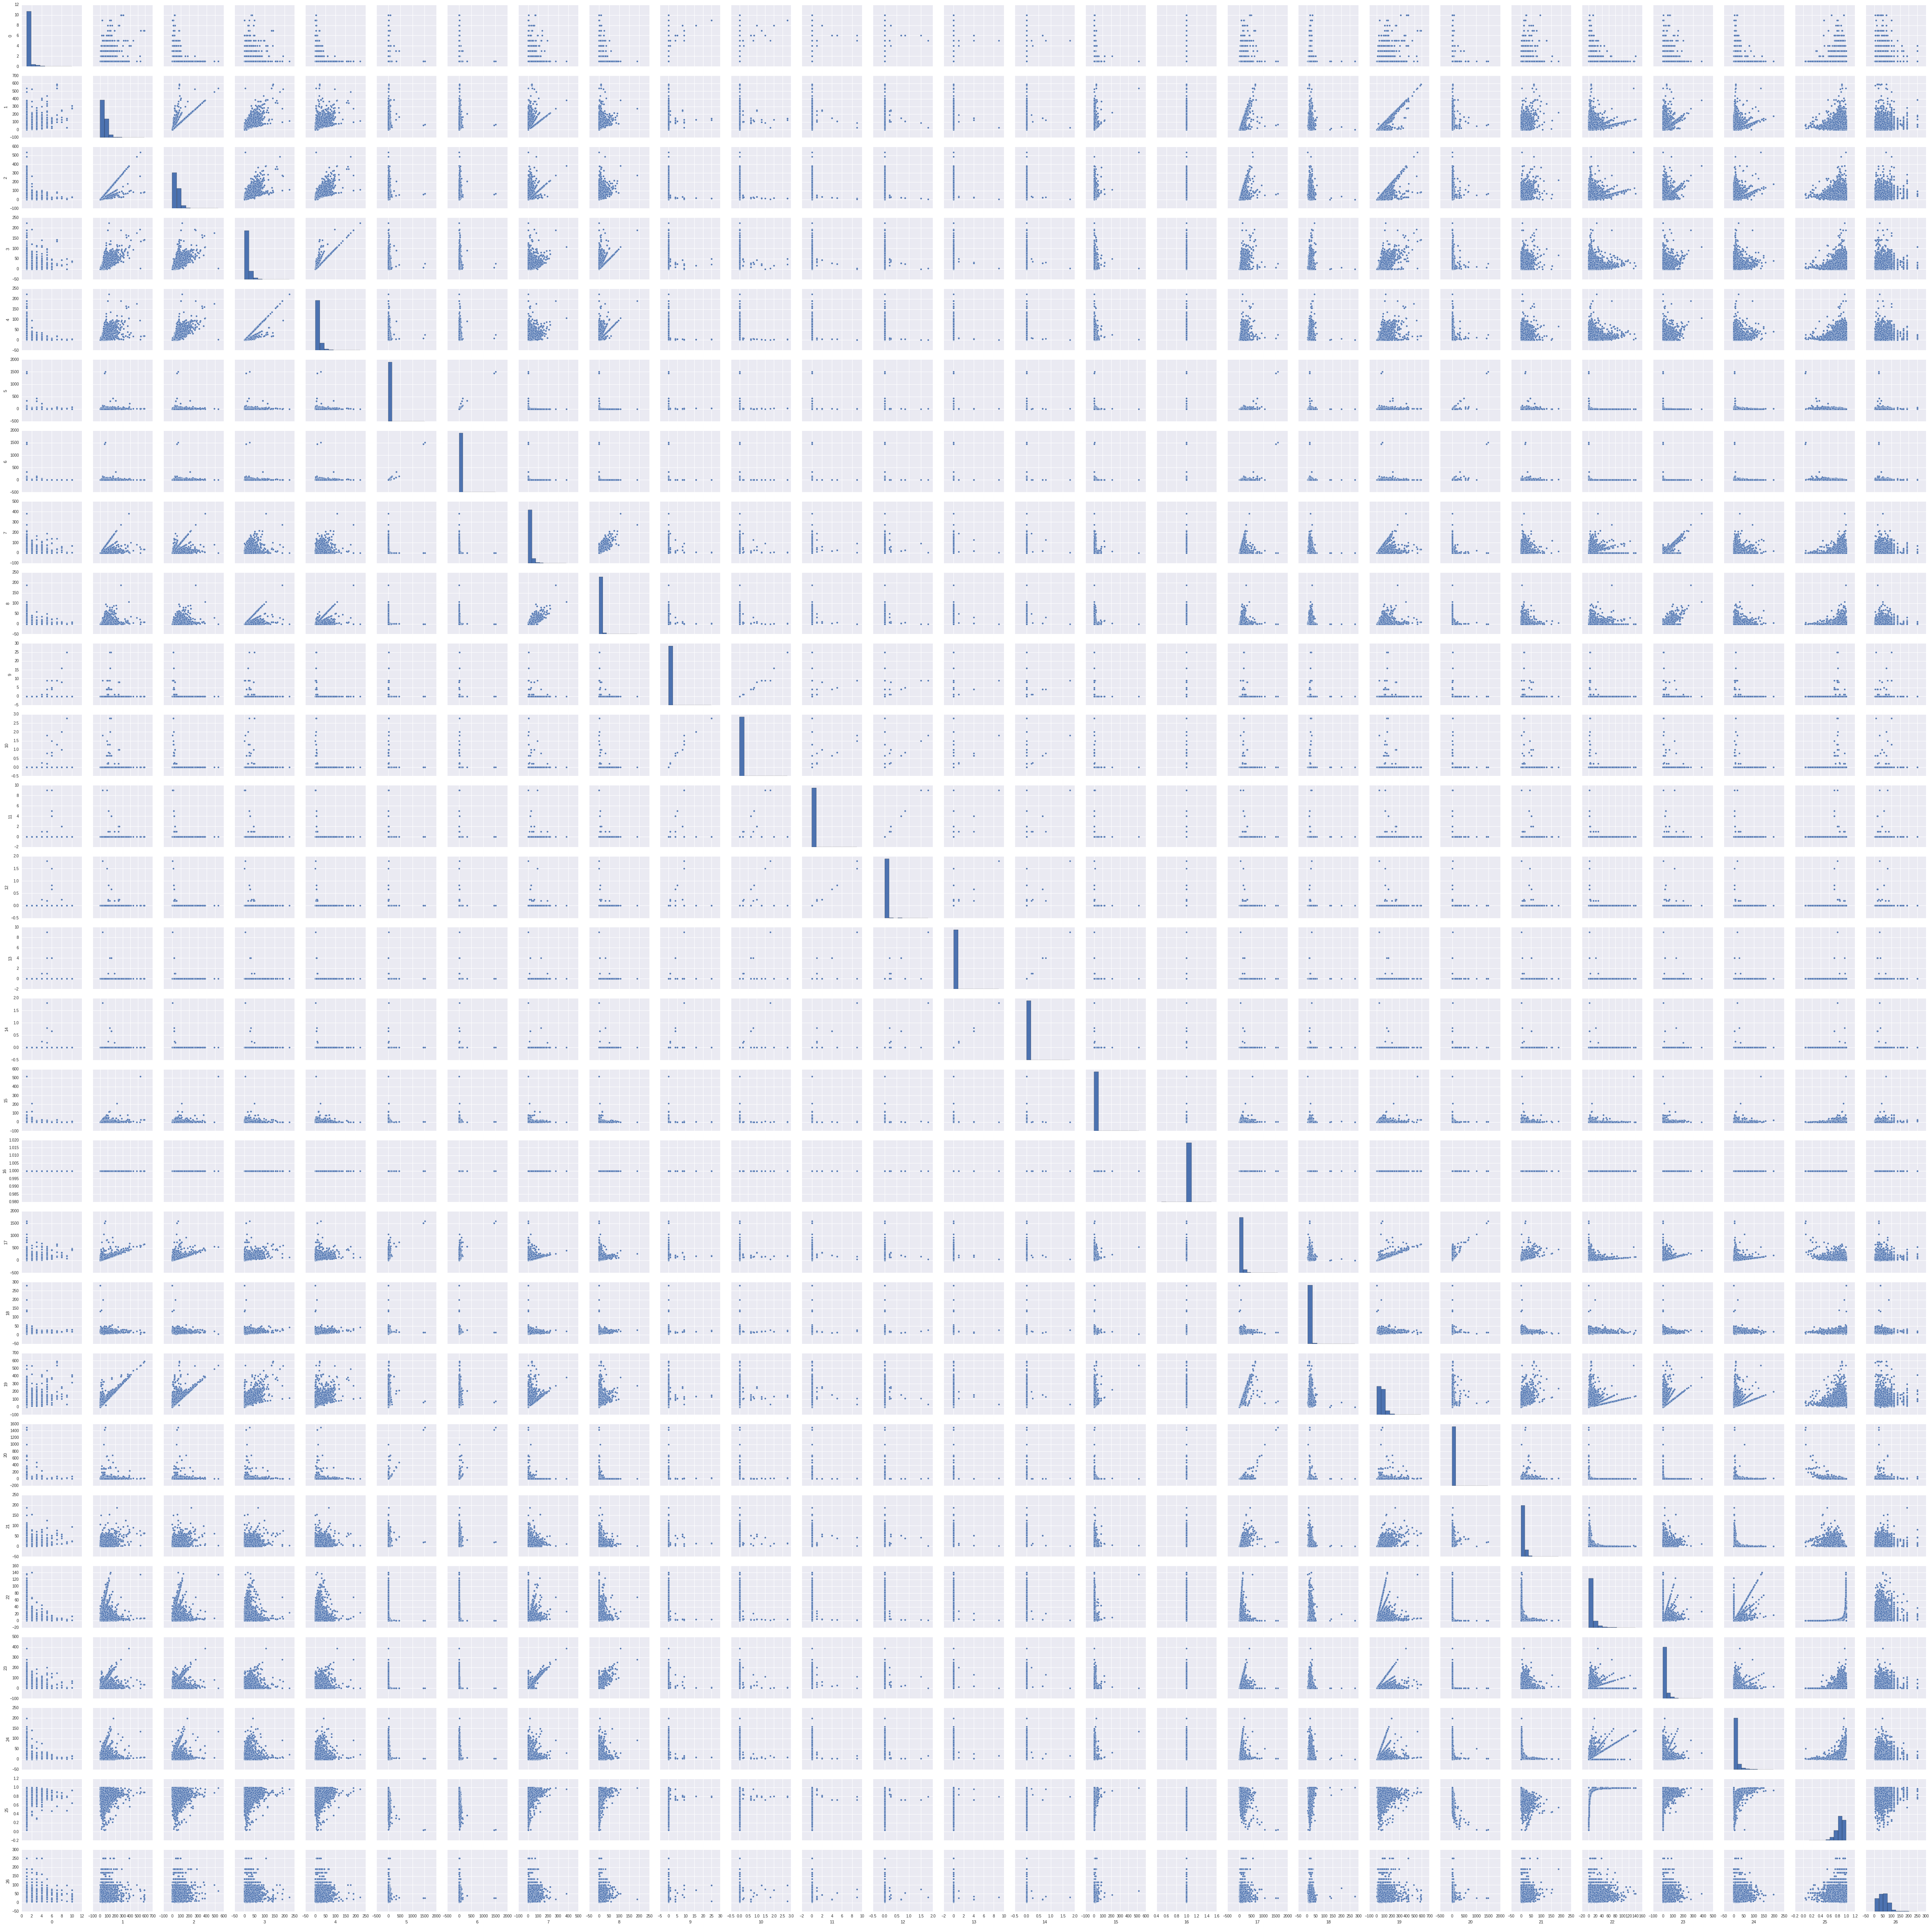

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(dataset)
sns.pairplot(df)
plt.show()